# Section 4: Machine Learning

In this section, we will deploy several machine learning algorithms to build a classifier (or classifiers) to predict the severity of the car accidents in the U.S. We will also verify some of our observations from the EDA section.

## 4.1 Setting up

Let's import the required libraries!

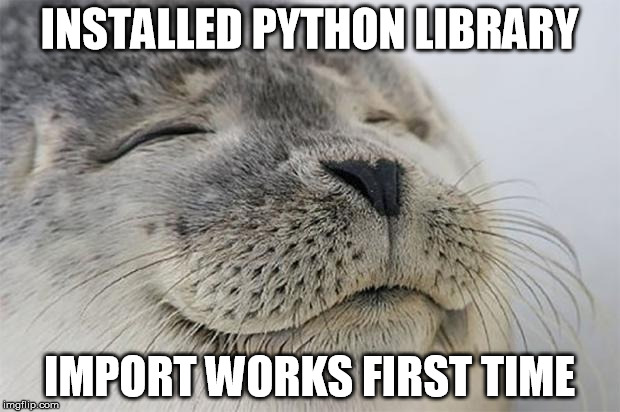

In [ ]:
#@title
#get access to the US car accidents csv file
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#@title
#data wrangling and visualization
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

#machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

#misc
from collections import Counter 
import re
import os
import io


import warnings
warnings.filterwarnings("ignore")

In [ ]:
#@title
#read the file to a Pandas Dataframe
acc_df = pd.read_csv('/content/drive/MyDrive/US_Accidents_June20.csv')

## 4.2 Feature Exploration

In [ ]:
#@title
print('Number of records and features: ', acc_df.shape)

Number of records and features:  (3513617, 49)


In [ ]:
#@title
print('Features Columns:', acc_df.columns)

Features Columns: Index(['ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
       'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State',
       'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')


This is a massive data set with ~3.5 million records and 49 different features. Let's take a look at the top few rows to get a sense about the data.


In [ ]:
#@title
acc_df.head(2)

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,2584.0,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day


Let's take a closer look at what we're trying to predict, our "y label", or the severity of the accident.

In [ ]:
#@title
severity_count = acc_df['Severity'].value_counts().rename_axis('severity_level').reset_index(name='num_accidents')
severity_count

,severity_level,num_accidents
0,2,2373210
1,3,998913
2,4,112320
3,1,29174


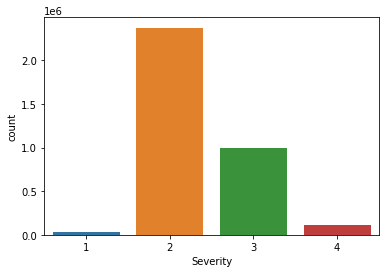

In [ ]:
#@title
sb.countplot(x=acc_df['Severity'])

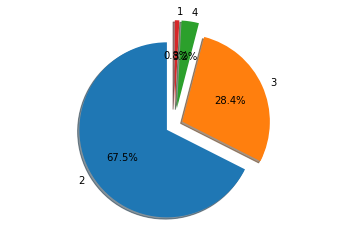

In [ ]:
#@title
explode = (0.1, 0.1, 0.2 ,0.2) 
fig1, ax1 = plt.subplots()
ax1.pie(severity_count['num_accidents'], explode=explode, labels=severity_count['severity_level'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

We note that the majority of the accidents fall into category 2 and 3 in terms of severity. We might have to deal with class imbalance issue.

In [ ]:
#@title
#create a new column for severity category 4
acc_df['Severity4'] = 0
acc_df.loc[acc_df['Severity'] == 4, 'Severity4'] = 1
acc_df.Severity4.value_counts()

0    3401297
1     112320
Name: Severity4, dtype: int64

Assume that Severity Level 4 is the most severe category. Let's try to plot the US Car Accidents map with longitude and latitude where these most severe accidents usually happened.

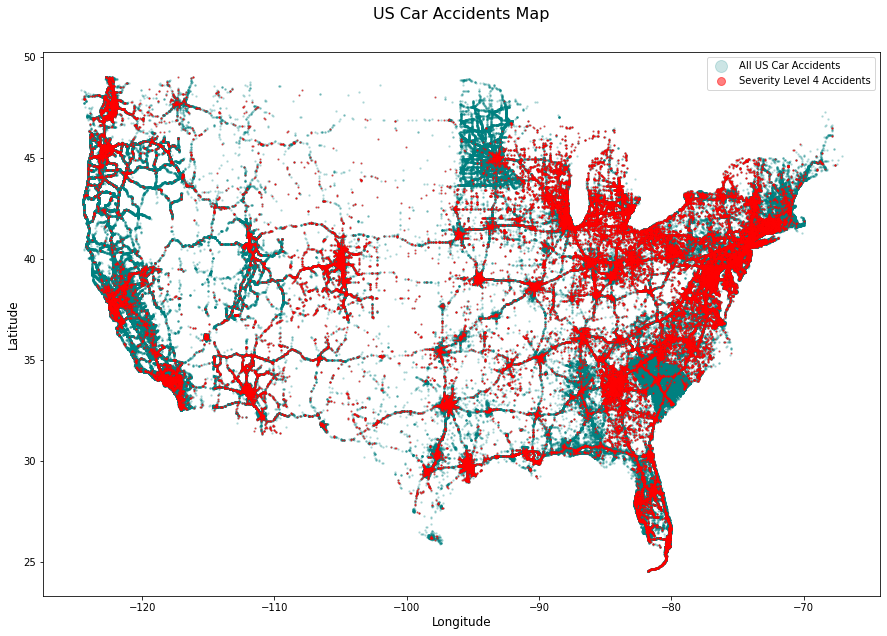

In [ ]:
#@title
map_df = acc_df[acc_df['Severity4']==1]

plt.figure(figsize=(15,10))

plt.plot('Start_Lng', 'Start_Lat', data=acc_df, linestyle='', marker='o', markersize=1.5, color="teal", alpha=0.2, label='All US Car Accidents')
plt.plot('Start_Lng', 'Start_Lat', data=map_df, linestyle='', marker='o', markersize=1, color="red", alpha=0.5, label='Severity Level 4 Accidents')
plt.legend(markerscale=8)
plt.xlabel('Longitude', size=12, labelpad=3)
plt.ylabel('Latitude', size=12, labelpad=3)
plt.title('US Car Accidents Map', size=16, y=1.05)
plt.show()

## 4.3 Data Preprocessing

### 4.3.1 Weather Condition

According to Perrels et al. (https://www.researchgate.net/publication/284903283_Weather_Conditions_Weather_Information_and_Car_Crashes), weather condition has a very strong relationship with car crashes. Let's take a deep look at this feature and do some data preprocessing.

In [ ]:
#@title
#look at unique values of weather condition
print("Weather Condition: ", "\n", acc_df['Weather_Condition'].unique())
print('\n')
print("Total Unique Conditions: ", acc_df['Weather_Condition'].nunique())

Weather Condition:  
 ['Light Rain' 'Overcast' 'Mostly Cloudy' 'Rain' 'Light Snow' 'Haze'
 'Scattered Clouds' 'Partly Cloudy' 'Clear' 'Snow'
 'Light Freezing Drizzle' 'Light Drizzle' 'Fog' 'Shallow Fog' 'Heavy Rain'
 'Light Freezing Rain' 'Cloudy' 'Drizzle' nan 'Light Rain Showers' 'Mist'
 'Smoke' 'Patches of Fog' 'Light Freezing Fog' 'Light Haze'
 'Light Thunderstorms and Rain' 'Thunderstorms and Rain' 'Fair'
 'Volcanic Ash' 'Blowing Sand' 'Blowing Dust / Windy' 'Widespread Dust'
 'Fair / Windy' 'Rain Showers' 'Mostly Cloudy / Windy'
 'Light Rain / Windy' 'Hail' 'Heavy Drizzle' 'Showers in the Vicinity'
 'Thunderstorm' 'Light Rain Shower' 'Light Rain with Thunder'
 'Partly Cloudy / Windy' 'Thunder in the Vicinity' 'T-Storm'
 'Heavy Thunderstorms and Rain' 'Thunder' 'Heavy T-Storm' 'Funnel Cloud'
 'Heavy T-Storm / Windy' 'Blowing Snow' 'Light Thunderstorms and Snow'
 'Heavy Snow' 'Low Drifting Snow' 'Light Ice Pellets' 'Ice Pellets'
 'Squalls' 'N/A Precipitation' 'Cloudy / Windy' 'Ligh

There are a total 127 unique weather conditions but a lot of them overlap. Let's try to group them together.

In [ ]:
#@title
weather_cond ='!'.join(acc_df['Weather_Condition'].dropna().unique().tolist())
weather_cond = np.unique(np.array(re.split(
    "!|\s/\s|\sand\s|\swith\s|Partly\s|Mostly\s|Blowing\s|Freezing\s", weather_cond))).tolist()
weather_cond

['',
 'Clear',
 'Cloudy',
 'Drifting Snow',
 'Drizzle',
 'Dust',
 'Dust Whirls',
 'Dust Whirls Nearby',
 'Dust Whirlwinds',
 'Fair',
 'Fog',
 'Funnel Cloud',
 'Hail',
 'Haze',
 'Heavy ',
 'Heavy Drizzle',
 'Heavy Ice Pellets',
 'Heavy Rain',
 'Heavy Rain Shower',
 'Heavy Rain Showers',
 'Heavy Sleet',
 'Heavy Smoke',
 'Heavy Snow',
 'Heavy T-Storm',
 'Heavy Thunderstorms',
 'Ice Pellets',
 'Light ',
 'Light Drizzle',
 'Light Fog',
 'Light Hail',
 'Light Haze',
 'Light Ice Pellets',
 'Light Rain',
 'Light Rain Shower',
 'Light Rain Showers',
 'Light Sleet',
 'Light Snow',
 'Light Snow Grains',
 'Light Snow Shower',
 'Light Snow Showers',
 'Light Thunderstorm',
 'Light Thunderstorms',
 'Low Drifting Snow',
 'Mist',
 'N/A Precipitation',
 'Overcast',
 'Partial Fog',
 'Patches of Fog',
 'Rain',
 'Rain Shower',
 'Rain Showers',
 'Sand',
 'Scattered Clouds',
 'Shallow Fog',
 'Showers in the Vicinity',
 'Sleet',
 'Small Hail',
 'Smoke',
 'Snow',
 'Snow Grains',
 'Snow Showers',
 'Squalls',
 '

There are still quite a lot of overlapping here. Let's come up with some major categories such as "Cloud", "Rain", "Snow", etc.

In [ ]:
#@title
acc_df['Clear'] = np.where(acc_df['Weather_Condition'].str.contains('Clear', case=False, na = False), 1, 0)
acc_df['Cloud'] = np.where(acc_df['Weather_Condition'].str.contains('Cloud|Overcast', case=False, na = False), 1, 0)
acc_df['Rain'] = np.where(acc_df['Weather_Condition'].str.contains('Rain|Storm|Hail|Drizzle', case=False, na = False), 1, 0)
acc_df['Heavy_Rain'] = np.where(acc_df['Weather_Condition'].str.contains('Heavy Rain|Rain Shower|Heavy T-Storm|Heavy Thunderstorms', case=False, na = False), 1, 0)
acc_df['Snow'] = np.where(acc_df['Weather_Condition'].str.contains('Snow|Sleet|Ice', case=False, na = False), 1, 0)
acc_df['Heavy_Snow'] = np.where(acc_df['Weather_Condition'].str.contains('Heavy Snow|Heavy Sleet|Heavy Ice Pellets|Snow Showers|Squalls', case=False, na = False), 1, 0)
acc_df['Fog'] = np.where(acc_df['Weather_Condition'].str.contains('Fog', case=False, na = False), 1, 0)
acc_df['Dust'] = np.where(acc_df['Weather_Condition'].str.contains('Dust|Smoke|Ash|Haze', case=False, na = False), 1, 0)
acc_df['Thunder'] = np.where(acc_df['Weather_Condition'].str.contains('Thunder|T-Storm', case=False, na = False), 1, 0)

In [ ]:
#@title
#handle missing value in weather
weather_clean = ['Clear','Cloud','Rain','Heavy_Rain','Snow','Heavy_Snow','Fog', 'Dust', 'Thunder']

for w in weather_clean:
  acc_df.loc[acc_df['Weather_Condition'].isnull(),w] = acc_df.loc[acc_df['Weather_Condition'].isnull(),'Weather_Condition']

In [ ]:
#@title
#take a look at a sample of clean data
acc_df.loc[:,['Weather_Condition'] + weather_clean].sample(20)

,Weather_Condition,Clear,Cloud,Rain,Heavy_Rain,Snow,Heavy_Snow,Fog,Dust,Thunder
2369543,Mostly Cloudy,0,1,0,0,0,0,0,0,0
2454616,Partly Cloudy,0,1,0,0,0,0,0,0,0
1665209,Clear,1,0,0,0,0,0,0,0,0
3456216,Partly Cloudy,0,1,0,0,0,0,0,0,0
2521989,Overcast,0,1,0,0,0,0,0,0,0
486734,Clear,1,0,0,0,0,0,0,0,0
2886861,Partly Cloudy,0,1,0,0,0,0,0,0,0
2747170,Fair,0,0,0,0,0,0,0,0,0
1969107,Overcast,0,1,0,0,0,0,0,0,0
3477905,Mostly Cloudy,0,1,0,0,0,0,0,0,0


In [ ]:
#@title
# acc_df[acc_df['Weather_Condition'] == 'N/A Precipitation'].head(2)

### 4.3.2 Wind Direction

We perform the same procedure with wind directions.

In [ ]:
#@title
# unique value of wind direction
print("Wind Direction: ", acc_df['Wind_Direction'].unique())

Wind Direction:  ['Calm' 'SW' 'SSW' 'WSW' 'WNW' 'NW' 'West' 'NNW' 'NNE' 'South' 'North'
 'Variable' 'SE' 'SSE' 'ESE' 'East' 'NE' 'ENE' 'E' 'W' nan 'S' 'VAR'
 'CALM' 'N']


In [ ]:

acc_df.loc[(acc_df['Wind_Direction']=='South')|(acc_df['Wind_Direction']=='SSW')|(acc_df['Wind_Direction']=='SSE'),'Wind_Direction'] = 'S'
acc_df.loc[(acc_df['Wind_Direction']=='West')|(acc_df['Wind_Direction']=='WSW')|(acc_df['Wind_Direction']=='WNW'),'Wind_Direction'] = 'W'
acc_df.loc[(acc_df['Wind_Direction']=='North')|(acc_df['Wind_Direction']=='NNW')|(acc_df['Wind_Direction']=='NNE'),'Wind_Direction'] = 'N'
acc_df.loc[(acc_df['Wind_Direction']=='East')|(acc_df['Wind_Direction']=='ESE')|(acc_df['Wind_Direction']=='ENE'),'Wind_Direction'] = 'E'
acc_df.loc[acc_df['Wind_Direction']=='Variable','Wind_Direction'] = 'VAR'
acc_df.loc[acc_df['Wind_Direction']=='Calm','Wind_Direction'] = 'CALM'

print('Clean Wind Direction: ', acc_df['Wind_Direction'].unique())

Clean Wind Direction:  ['CALM' 'SW' 'S' 'W' 'NW' 'N' 'VAR' 'SE' 'E' 'NE' nan]


Instead of using 30+ categories for wind direction, now we only have 10.

### 4.3.3 Street Type

This article (https://www.cga.ct.gov/2013/rpt/2013-R-0074.htm) shows that there is a connection between speed limit increases and accident rates. While it would be ideal to have data with the street's speed limit, we attempt to estimate it by identifying street type.

In [ ]:
#@title
print("Number of Unique Street Type: ", acc_df['Street'].nunique())

Number of Unique Street Type:  176262


We can't go over all 176k street types to filter down like what we did with weather condition. Let's just look at the top 50 common street types.

In [ ]:
#@title
street_type =' '.join(acc_df['Street'].unique().tolist()) 
street_type = re.split(" |-", street_type) 
street_type = [x[0] for x in Counter(street_type).most_common(50)] 
print('50 Most Common Street Type: ')
print(*street_type, sep = ", ")

50 Most Common Street Type: 
Rd, , Dr, St, Ave, N, S, E, W, Ln, Blvd, Highway, Way, Ct, State, Hwy, NE, Pkwy, SW, Pl, SE, NW, Road, Old, Cir, Route, US, Creek, Hill, Park, County, Lake, Trl, Valley, Ridge, Mill, River, Pike, Oak, Ter, I, Loop, Canyon, Church, Springs, Bridge, Mountain, New, Avenue, Saint


We handpick some popular/common street types based on this information from USPS: https://pe.usps.com/text/pub28/28apc_002.htm

In [ ]:
#@title
street_type = [' Ave', ' Blvd', ' Ct', ' Dr', ' Rd', ' St',  ' Ln', ' Highway', ' Pkwy', ' Hwy', 
          ' Way' , 'Pl', ' Road', 'US-', 'Creek', ' Cir', 'Hill', 'Route', 
          'I-', 'Trl', 'Valley', 'Ridge', 'Pike', ' Fwy', 'River']
print(*street_type, sep = ", ") 

 Ave,  Blvd,  Ct,  Dr,  Rd,  St,  Ln,  Highway,  Pkwy,  Hwy,  Way, Pl,  Road, US-, Creek,  Cir, Hill, Route, I-, Trl, Valley, Ridge, Pike,  Fwy, River


Let's look at the correlation between the street type and how severe an accident is.

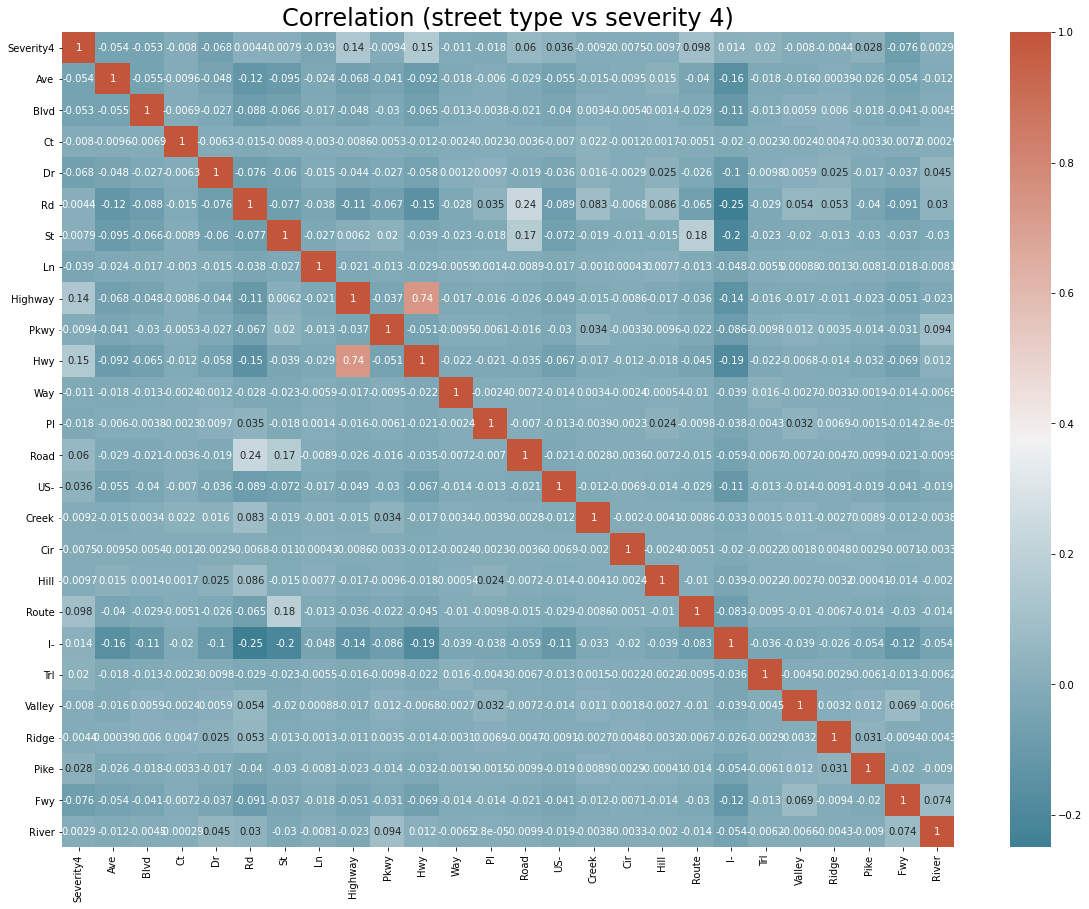

In [ ]:
#@title
for i in street_type:
  acc_df[i.strip()] = np.where(acc_df['Street'].str.contains(i, case=True, na = False), 1, 0)
acc_df.loc[acc_df['Road']==1,'Rd'] = 1
acc_df.loc[acc_df['Highway']==1,'Hwy'] = 1

#resample due to the huge size of our data
df_sample = pd.concat([acc_df[acc_df['Severity4']==1].sample(50000, replace = True), 
                   acc_df[acc_df['Severity4']==0].sample(50000)], axis=0)

# plot correlation
df_sample['Severity4'] = df_sample['Severity4'].astype(int)
street_corr  = df_sample.loc[:,['Severity4']+[x.strip() for x in street_type]].corr()
plt.figure(figsize=(20,15))
cmap = sb.diverging_palette(220, 20, as_cmap=True)
sb.heatmap(street_corr, cmap=cmap, annot=True).set_title("Correlation (street type vs severity 4)", fontsize = 24)
plt.show()

## 4.4 Feature Engineering

Feature engineering is to use existing features to create new features to determine if they provide new signals to predict the outcome. From the EDA section, we've learned that the time it takes to clear an accident might give us some information about how severe that accident was. Let's try to extract this information!

### 4.4.1 Feature Extraction

In [ ]:
#@title
#convert start time and end time to the right format
acc_df['Start_Time'] = pd.to_datetime(acc_df['Start_Time'], errors='coerce')
acc_df['End_Time'] = pd.to_datetime(acc_df['End_Time'], errors='coerce')

In [ ]:
#@title
#extract year, month, day, hour, and weekday of the accident from start and end time
acc_df['Year']=acc_df['Start_Time'].dt.year
acc_df['Month']=acc_df['Start_Time'].dt.strftime('%b')
acc_df['Day']=acc_df['Start_Time'].dt.day
acc_df['Hour']=acc_df['Start_Time'].dt.hour
acc_df['Weekday']=acc_df['Start_Time'].dt.strftime('%a')

In [ ]:
#@title
#calculate the duration of the accident in minute
acc_df['acc_duration(min)']=round((acc_df['End_Time']-acc_df['Start_Time'])/np.timedelta64(1,'m'))

In [ ]:
#@title
#let's take a look at our new features
acc_df.head(2)

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,...,Clear,Cloud,Rain,Heavy_Rain,Snow,Heavy_Snow,Fog,Dust,Thunder,Ave,Blvd,Ct,Dr,Rd,St,Ln,Highway,Pkwy,Hwy,Way,Pl,Road,US-,Creek,Cir,Hill,Route,I-,Trl,Valley,Ridge,Pike,Fwy,River,Year,Month,Day,Hour,Weekday,acc_duration(min)
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,CALM,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2016,Feb,8,5,Mon,314.0
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,2584.0,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,CALM,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,...,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016,Feb,8,6,Mon,30.0


### 4.4.2 Outlier Analysis

We do a sanity check to find out if there are any outliers we need to handle from this new feature. There are negative durations that should be removed.

In [ ]:
#@title
#records with negative duration
acc_df['acc_duration(min)'][acc_df['acc_duration(min)'] <= 0]

69719      -0.0
69720      -0.0
69721      -0.0
69722      -1.0
69723      -1.0
309387    -30.0
309388    -30.0
860988    -12.0
861024    -31.0
861041     -0.0
861475    -14.0
861494     -0.0
861495    -30.0
1497823   -30.0
1497824   -31.0
2234574   -30.0
2234659   -30.0
2234660   -31.0
3104499   -34.0
3104975    -7.0
3104978    -7.0
3232740   -31.0
Name: acc_duration(min), dtype: float64

In [ ]:
#@title
#remove the records with negative duration
acc_df['acc_duration(min)'][acc_df['acc_duration(min)'] <= 0] = np.nan
acc_df.dropna(subset=['acc_duration(min)'], inplace=True)

Looking closer at the time it takes to clear an accident, we note something very unusual.

In [ ]:
#@title
acc_df[acc_df['acc_duration(min)']==acc_df['acc_duration(min)'].max()]

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,...,Clear,Cloud,Rain,Heavy_Rain,Snow,Heavy_Snow,Fog,Dust,Thunder,Ave,Blvd,Ct,Dr,Rd,St,Ln,Highway,Pkwy,Hwy,Way,Pl,Road,US-,Creek,Cir,Hill,Route,I-,Trl,Valley,Ridge,Pike,Fwy,River,Year,Month,Day,Hour,Weekday,acc_duration(min)
2740847,A-2740902,Bing,NaN,2,2017-08-16 14:07:14,2020-04-30 01:22:43,40.02935,-80.31546,40.02935,-80.31546,0.0,At PA-231/E Finley Dr - Fuel spillage accident.,1.0,Sparta Rd,R,Prosperity,Washington,PA,15329-1467,US,US/Eastern,KAFJ,2017-08-16 14:15:00,80.6,NaN,54.0,30.08,10.0,CALM,NaN,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2017,Aug,16,14,Wed,1421955.0
2740848,A-2740903,Bing,NaN,2,2017-08-16 14:07:14,2020-04-30 01:22:43,40.02935,-80.31546,40.02935,-80.31546,0.0,At Grove Rd - Fuel spillage accident.,1.0,Sparta Rd,R,Prosperity,Washington,PA,15329-1467,US,US/Eastern,KAFJ,2017-08-16 14:15:00,80.6,NaN,54.0,30.08,10.0,CALM,NaN,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2017,Aug,16,14,Wed,1421955.0


This accident took us almost 3 years to clear! That doesn't seem right. It could be due to some data entry error, or you know, it IS actually the time it took to clear this accident. However, we don't want these outliers to skew our data, so let's remove them. A safe way to do this is to remove any records that have accident duration which is greater than 2 standard deviations way from the mean accident duration.


In [ ]:
#@title
#remove observations that have accident duration which is greater than 2 standard deviation from the mean

outliers = (acc_df['acc_duration(min)'] - acc_df['acc_duration(min)'].mean()).abs() > acc_df['acc_duration(min)'].std()*2
acc_df[outliers] = np.nan
acc_df['acc_duration(min)'].fillna(acc_df['acc_duration(min)'].mean(), inplace=True)

Let's plot out the distribution of the accident duration feature!

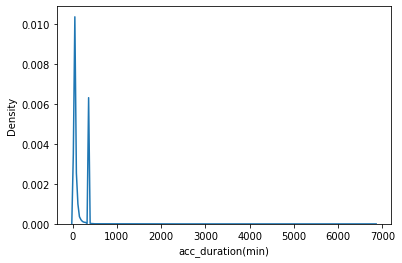

In [ ]:
#@title
sb.kdeplot(data=acc_df, x="acc_duration(min)")

### 4.4.3 Handling Missing Data

There are a lot of missing data in our data set. Missing values can be bad, because some algorithms don't know how-to handle null values and will fail. While others, like decision trees, can handle null values. Thus, it's important to address this problem before we start modeling. There are two common methods, either delete the record or populate the missing value using a reasonable input. In general, it is not recommended to delete the record, especially a large percentage of records, unless it truly represents an incomplete record. The best approach is to impute missing values. Let's take a look at the number of missing values in each column feature.

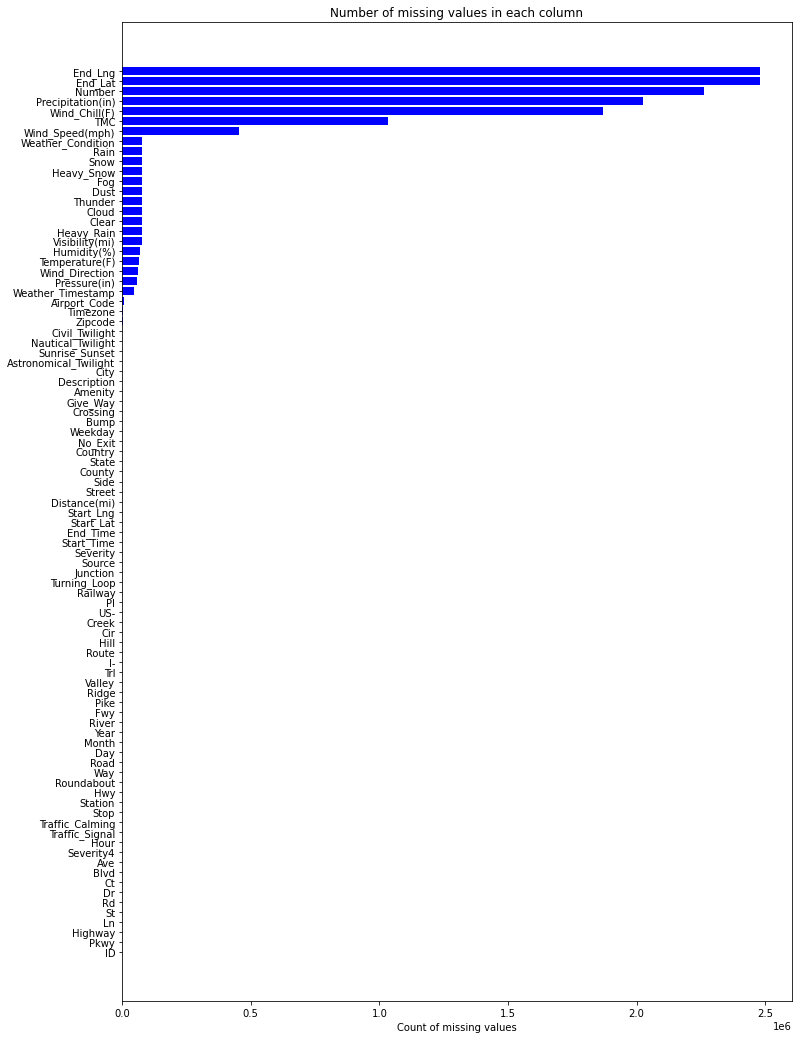

In [ ]:
#@title
missing_df = acc_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name','missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.5
fig,ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind,missing_df.missing_count.values,color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

While it's not recommended to drop the records with missing values, we have a lot of data, probably more than what we need to train our classifier. Under the scope of this project, we decided to go with this route. 

Due to the massive amount of data, it will take a long time to train our models. We decided to train with a subset of the available data. We filter out all the records from PA state as our chosen subset. Below is a quick look at PA and where the accidents happened.

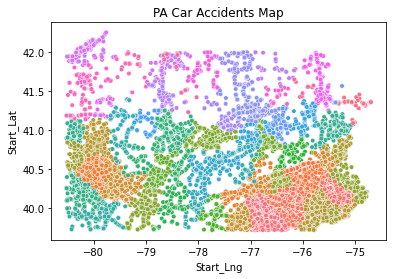

In [ ]:
#@title
state = 'PA'
df_state = acc_df.loc[acc_df['State']==state].copy()
df_state.drop('State',axis=1, inplace=True)
sb.scatterplot(x='Start_Lng', y='Start_Lat', data=df_state, hue='County', legend=False, s=20).set_title('PA Car Accidents Map')
plt.show()

Next step is to decide what features we're going to use for our model. We do not include IDs, number, street side, country, timezone, airport, weather time stamp, and other columns with a lot of missing values (end_lat, end_lng, precipitation, etc.) 

In [ ]:

#exclude ID - no predictive power
#number, street side, country, timezone, airport(?), weather time stamp
#columns with a lot of missing values

#state, airport_code

col_to_use = ['Start_Lat', 'Start_Lng', 'State', 
              
              'Ave', 'Blvd', 'Ct', 'Dr', 'Rd', 'St',  'Ln', 'Highway', 'Pkwy', 'Hwy', 
              'Way' , 'Pl', 'Road', 'US-', 'Creek', 'Cir', 'Hill', 'Route', 
              'I-', 'Trl', 'Valley', 'Ridge', 'Pike', 'Fwy', 'River',

              'Temperature(F)','Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
              
              'Clear','Cloud','Rain','Heavy_Rain','Snow','Heavy_Snow','Fog', 'Dust', 'Thunder',

              'Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop',
              'Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset','Civil_Twilight','Nautical_Twilight',
              'Astronomical_Twilight', 'Hour','Weekday', 'acc_duration(min)', 'Severity']

In [ ]:
#@title
#create a new dataframe with the columns we need
acc_df = acc_df[col_to_use]

In [ ]:
#@title
#drop records with missing values
acc_df.dropna(subset=acc_df.columns[acc_df.isnull().mean()!=0], how='any', axis=0, inplace=True)
acc_df.shape

(3402007, 63)

Even after dropping all the records with missing values, we are still left with a bit more than 3.4 million records.

In [ ]:
#@title
state = 'PA'
df_state = acc_df.loc[acc_df['State']==state].copy()
df_state.drop('State',axis=1, inplace=True)

In [ ]:
#@title
df_state.shape

(104297, 62)

We have more thann 100k records from PA. This should be enough to train our model.

### 4.4.4 Data Scaling and Standardizing

Before training our classifiers, we need to convert categorical values to numeric values, standardize the values, and split the data into training set and testing set. Note that to deal with class imbalance issue, we use stratify method when splitting the data to keep the ratios among different categories.

In [ ]:
#@title
#one-hot encode to convert categorical to numerical
df_state = pd.get_dummies(df_state)
df_state.shape

(104297, 90)

In [ ]:
#@title
#standadize the data
scaler = StandardScaler()
scaler.fit_transform(df_state)
df_state.head()

,Start_Lat,Start_Lng,Ave,Blvd,Ct,Dr,Rd,St,Ln,Highway,Pkwy,Hwy,Way,Pl,Road,US-,Creek,Cir,Hill,Route,I-,Trl,Valley,Ridge,Pike,Fwy,River,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,...,Wind_Direction_NE,Wind_Direction_NW,Wind_Direction_S,Wind_Direction_SE,Wind_Direction_SW,Wind_Direction_VAR,Wind_Direction_W,Clear_0,Clear_1,Cloud_0,Cloud_1,Rain_0,Rain_1,Heavy_Rain_0,Heavy_Rain_1,Snow_0,Snow_1,Heavy_Snow_0,Heavy_Snow_1,Fog_0,Fog_1,Dust_0,Dust_1,Thunder_0,Thunder_1,Sunrise_Sunset_Day,Sunrise_Sunset_Night,Civil_Twilight_Day,Civil_Twilight_Night,Nautical_Twilight_Day,Nautical_Twilight_Night,Astronomical_Twilight_Day,Astronomical_Twilight_Night,Weekday_Fri,Weekday_Mon,Weekday_Sat,Weekday_Sun,Weekday_Thu,Weekday_Tue,Weekday_Wed
197865,41.338398,-74.837120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,28.9,85.0,30.54,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0
208994,41.408066,-74.914040,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.2,60.0,30.27,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1
214862,41.324230,-74.806488,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.9,69.0,30.28,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1
228550,40.057697,-76.765587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,54.0,100.0,29.70,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1
228553,40.301609,-75.647789,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0,100.0,29.74,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1


In [ ]:
#@title
#extract y label
y = df_state['Severity']

In [ ]:
#@title
#feature columns
X = df_state.drop('Severity', axis=1)

In [ ]:
#@title
#train-test-split with stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

## 4.5 Classical Machine Learning 

This is a multi-class classification problem. We have several algorithms to consider. Let's look at each of them and see how they perform with the PA subset.

### 4.5.1 Logistic Regression

In [ ]:
#@title
%%time
lr = LogisticRegression(max_iter = 3000)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy: %.1f%%"% (acc_lr*100))

Logistic Regression Accuracy: 80.6%
CPU times: user 5min 53s, sys: 6min 43s, total: 12min 37s
Wall time: 3min 10s


Logistic regression is very intuitive and easy to understand. However, the major limitation of logistic regression is the assumption of linearity between the dependent variable and the independent variables. Non-linear problems can’t be solved with logistic regression because it has a linear decision surface. Linearly separable data is rarely found in real-world scenarios.

Logistic regression usually gets outperformed by other algorithms.

### 4.5.2 K-Nearest Neighbor

In [ ]:
%%time
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

acc_knn = accuracy_score(y_test, y_pred)
print("KNN Accuracy: %.1f%%"% (acc_knn*100))

KNN Accuracy: 75.7%
CPU times: user 9.76 s, sys: 1.77 ms, total: 9.77 s
Wall time: 9.77 s


KNN is another intuitive and easy to understand algorithm. However, KNN doesn't perform very well with this data set. KNN works well with a small number of input variables but as the numbers of variables grow KNN algorithm tends to struggle a lot (curse of high dimensionality).

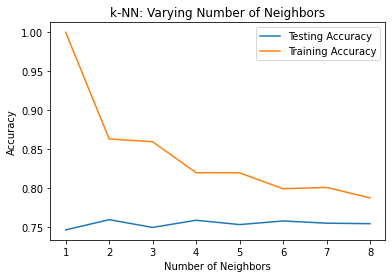

CPU times: user 4min 42s, sys: 117 ms, total: 4min 42s
Wall time: 4min 42s


In [ ]:
%%time
# find the best k
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i, n_neighbor in enumerate(neighbors):

    knn = KNeighborsClassifier(n_neighbors=n_neighbor)
    knn.fit(X_train,y_train)
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

We did some hyperparameter tuning to find the best k, but its accuracy is still pretty bad.

### 4.5.3 Decision Tree

In [ ]:
#@title
%%time
dt1 = DecisionTreeClassifier(max_depth=50, criterion='entropy')
dt1.fit(X_train,y_train)
y_pred = dt1.predict(X_test)

acc_dt1 = accuracy_score(y_test, y_pred)
print("Decision Tree Accuracy (Entropy): %.1f%%"% (acc_dt1*100))
print('\n')

dt2 = DecisionTreeClassifier(max_depth=50, criterion='gini')
dt2.fit(X_train,y_train)
y_pred = dt2.predict(X_test)

acc_dt2 = accuracy_score(y_test, y_pred)
print("Decision Tree Accuracy (Gini): %.1f%%"% (acc_dt2*100))


Decision Tree Accuracy (Entropy): 86.7%


Decision Tree Accuracy (Gini): 86.5%
CPU times: user 4.02 s, sys: 0 ns, total: 4.02 s
Wall time: 4.01 s


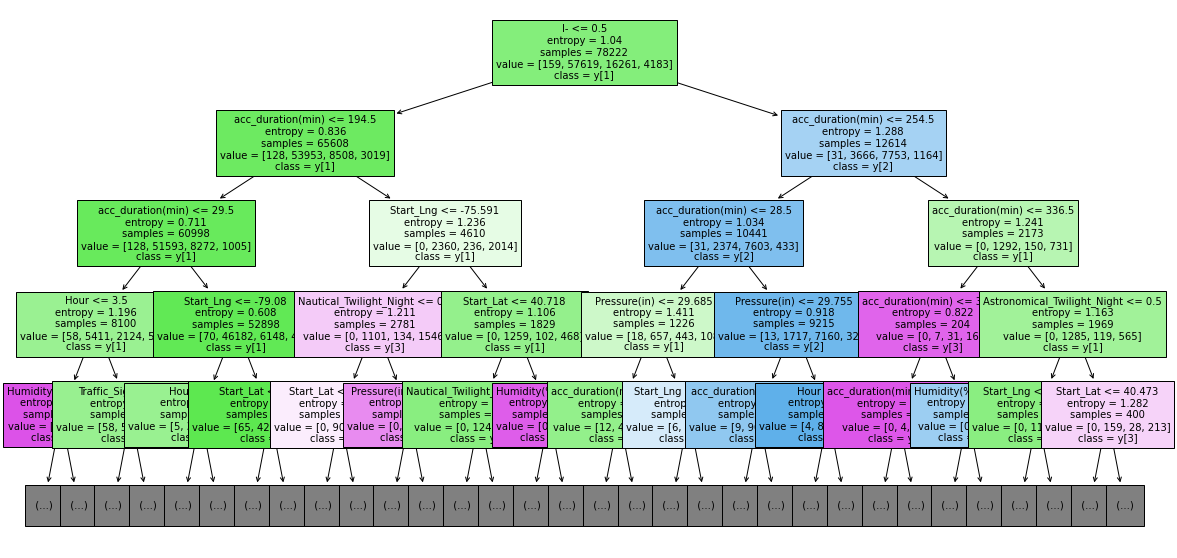

In [ ]:
#@title
fig, ax = plt.subplots(figsize=(20, 10))
tree.plot_tree(dt1, max_depth=4, fontsize=10,
               feature_names=df_state.drop('Severity',axis =1).columns.to_list(),
               class_names = True, filled=True)
plt.show()

Decision tree is also very intuitive and easy to explain. However, it overfits very easily and has a very high variance. A small change in the data can cause a large change in the structure of the decision tree causing instability.

### 4.5.4 Random Forest

In [ ]:
#@title
%%time
rf = RandomForestClassifier(n_estimators=500, max_depth=50)

rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy: %.1f%%"% (acc_rf*100))

Random Forest Accuracy:  0.8936529242569511
CPU times: user 1min 35s, sys: 176 ms, total: 1min 35s
Wall time: 1min 35s


Random forest is based on the bagging algorithm and uses ensemble learning technique. It creates many trees using a subset of the data and combines the outputs of all trees (majority vote). By doing this, random forest reduces overfitting problem in decision trees and also reduces the variance and therefore improves accuracy. Random forest algorithm is very stable. Even if a new data point is introduced to the dataset, the overall algorithm is not affected as much since the new data may impact one tree, but it is very hard for it to impact all the trees. 

The downside of random forest is that this algorithm requires a lot of computational power and resources. Also, it requires much longer time to train as compared to decision trees.

A very nice feature available from Sklearn RandomForestClassifier is Feature Importance Graph. From here we can see which features have the biggest impact on determining the severity of the accidents. We can see that our new feature, accident duration, appears in the top 10 features.

No handles with labels found to put in legend.


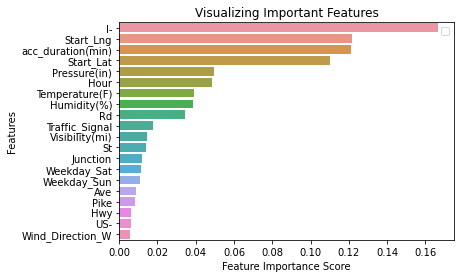

In [ ]:
#@title
feature_imp = pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=False)


k=20
sb.barplot(x=feature_imp[:20], y=feature_imp.index[:k])

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [ ]:
#@title
%%time
depth = [10,30,50]
nEstimator = [100,200,500]

grid = {'n_estimators' : nEstimator, 'max_depth': depth}

random_forest = RandomForestClassifier()

grid_search = GridSearchCV(estimator = random_forest, param_grid = grid)
grid_search.fit(X_train,y_train)

y_pred = grid_search.predict(X_test)

acc_grid = accuracy_score(y_test, y_pred)
print("Grid Search Accuracy: %.1f%%"% (acc_grid*100))


Grid Search Accuracy:  0.893869100111192
CPU times: user 16min 54s, sys: 3.56 s, total: 16min 57s
Wall time: 16min 57s


We use GridSearchCV to hyper-parameter tune our random forest.

### 4.5.5 AdaBoost

In [ ]:
#@title
%%time
ada = AdaBoostClassifier(n_estimators=200, learning_rate=0.01)

ada.fit(X_train,y_train)

y_pred = ada.predict(X_test)

acc_ada = accuracy_score(y_test, y_pred)
print("AdaBoost Accuracy: %.1f%%"% (acc_ada*100))


AdaBoost Accuracy: 79.6%
CPU times: user 30.3 s, sys: 0 ns, total: 30.3 s
Wall time: 30.2 s


AdaBoost (Adaptive Boosting) is a very popular boosting technique that aims at combining multiple weak classifiers to build one strong classifier. AdaBoost has a lot of advantages, mainly it is easier to use with less need for tweaking parameters unlike algorithms like SVM. However, AdaBoost is also extremely sensitive to noisy data and outliers.

### 4.5.6 XGBoost

In [ ]:
#@title
%%time
gbm = xgb.XGBClassifier(n_estimators= 1000, max_depth=20)

gbm.fit(X_train,y_train)

y_pred = gbm.predict(X_test)

acc_xgb = accuracy_score(y_test, y_pred)
print("XGBoost Accuracy: %.1f%%"% (acc_xgb*100))


XGBoost Accuracy: 92.0%
CPU times: user 57min 23s, sys: 0 ns, total: 57min 23s
Wall time: 57min 22s


XGBoost is a gradient boosting method, one of the best algorithms for classification problems. It handles large sized datasets very well with good execution speed. It can automatically handle missing values and apply regularized boosting method, thus less prone to overfitting. It also does pruning for you. XGBoost is a frequent winner in a lot of Kaggle competitions.

### 4.5.7 LightGBM

In [ ]:
%%time
lgbm = lgb.LGBMClassifier(n_estimators=1000, max_depth=50)

lgbm.fit(X_train,y_train)

y_pred = lgbm.predict(X_test)

acc_lgb = accuracy_score(y_test, y_pred)
print("LightGBM Accuracy: %.1f%%"% (acc_lgb*100))

LightGBM Accuracy: 91.1%
CPU times: user 1min 6s, sys: 0 ns, total: 1min 6s
Wall time: 1min 6s


## 4.6 Deep Learning

In [ ]:
from more_itertools import sliced
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [ ]:
text_df = pd.read_csv('/content/drive/MyDrive/US_Accidents_June20.csv')

In [ ]:
text_df = text_df[['Description', 'Severity']].sample(n=50000, random_state=42)

In [ ]:
text_df['Description']

3173614    Between Amsterdam Ave/Harlem River Dr and RT-9...
2560694                          At I-75/Exit 43 - Accident.
708186     Accident on I-520 Bobby Jones Expy Eastbound a...
2231588    Lane blocked and left hand shoulder blocked du...
1755423    Left lane blocked due to accident on I-87 Nort...
                                 ...                        
1221870    Accident on entry ramp to I-105 Westbound from...
1819282    Accident on Expressway Northbound at Columbia Rd.
2299676                    Accident on Lake Blvd at Club Dr.
2142067    Accident on US-61 Hastings Rd Southbound betwe...
1811559           Accident on Harvey Rd at Poplar Drive Ext.
Name: Description, Length: 50000, dtype: object

In [ ]:
# The maximum number of words to be used (most frequent)
max_num_words = 100
# Max number of words in each complaint
max_len = 500

embed_dim = 100
tokenizer = Tokenizer(num_words=max_num_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(text_df['Description'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 14586 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(text_df['Description'].values)
X = pad_sequences(X, maxlen=max_len)
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(text_df['Severity']).values
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (50000, 500)
Shape of label tensor: (50000, 4)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(45000, 500) (45000, 4)
(5000, 500) (5000, 4)


In [ ]:
model = Sequential()
model.add(Embedding(max_num_words, embed_dim, input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1, 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)])

Epoch 1/10
633/633 [==============================] - 1076s 2s/step - loss: 0.3712 - accuracy: 0.8764 - val_loss: 0.2969 - val_accuracy: 0.9033
Epoch 2/10
633/633 [==============================] - 1091s 2s/step - loss: 0.2867 - accuracy: 0.9077 - val_loss: 0.2827 - val_accuracy: 0.9062
Epoch 3/10
633/633 [==============================] - 1076s 2s/step - loss: 0.2769 - accuracy: 0.9095 - val_loss: 0.2809 - val_accuracy: 0.9062
Epoch 4/10
633/633 [==============================] - 1073s 2s/step - loss: 0.2726 - accuracy: 0.9101 - val_loss: 0.2785 - val_accuracy: 0.9062
Epoch 5/10
633/633 [==============================] - 1073s 2s/step - loss: 0.2688 - accuracy: 0.9105 - val_loss: 0.2765 - val_accuracy: 0.9073
Epoch 6/10
633/633 [==============================] - 1071s 2s/step - loss: 0.2655 - accuracy: 0.9105 - val_loss: 0.2757 - val_accuracy: 0.9076
Epoch 7/10
633/633 [==============================] - 1071s 2s/step - loss: 0.2635 - accuracy: 0.9112 - val_loss: 0.2767 - val_accuracy:

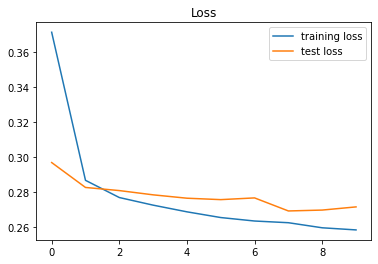

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.show();

In [ ]:
acc_lstm = model.evaluate(X_test,Y_test)
print('LSTM accuracy: %.1f%%'% (acc_lstm[1]*100))

157/157 [==============================] - 19s 123ms/step - loss: 0.2696 - accuracy: 0.9108
LSTM accuracy: 91.1%
